In [4]:
import pandas as pd
import joblib
import os
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [5]:
csv_path = os.path.join(os.getcwd(), 'src', 'DataSet', 'heart.csv')

df = pd.read_csv(csv_path)

df_atualizado = df.copy()




In [6]:
x = df_atualizado.drop('HeartDisease', axis=1)

y = df_atualizado['HeartDisease']

print("Balanceamento:\n", y.value_counts())

colunas_categoricas = ["Sex", "ChestPainType", "RestingECG", "ExerciseAngina", "ST_Slope"]
colunas_numericas = ["Age", "RestingBP", "Cholesterol", "FastingBS", "MaxHR", "Oldpeak"]


Balanceamento:
 HeartDisease
1    508
0    410
Name: count, dtype: int64


In [7]:
preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), colunas_numericas),
    ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), colunas_categoricas)
])

pipeline = Pipeline(steps=[
    ("preprocessamento", preprocessor),
    ("modelo", RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))])

x_train, x_test, y_train, y_test  = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)



In [8]:
param_grid = {
    'modelo__n_estimators': [100, 200, 300],
    'modelo__max_depth': [None, 10, 20],
    'modelo__min_samples_split': [2, 5, 10]
}

search = RandomizedSearchCV(pipeline, param_grid, n_iter=10, cv=5, random_state=42, scoring='recall')
search.fit(x_train, y_train)
print("Melhores parâmetros:", search.best_params_)

best_pipeline = search.best_estimator_



Melhores parâmetros: {'modelo__n_estimators': 300, 'modelo__min_samples_split': 2, 'modelo__max_depth': 10}


In [9]:

y_pred = best_pipeline.predict(x_test)

print("\nAcurácia:              ", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n",        confusion_matrix(y_test, y_pred))




Acurácia:               0.8858695652173914

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.85      0.87        82
           1       0.89      0.91      0.90       102

    accuracy                           0.89       184
   macro avg       0.89      0.88      0.88       184
weighted avg       0.89      0.89      0.89       184

Confusion Matrix:
 [[70 12]
 [ 9 93]]


In [10]:
scores = cross_val_score(best_pipeline, x, y, cv=5, scoring='recall')
print("\nRecall por rodada (CV):", scores)
print("Média de recall (CV):  ", scores.mean())


Recall por rodada (CV): [0.84313725 0.78431373 1.         0.88118812 0.74257426]
Média de recall (CV):   0.8502426713259561


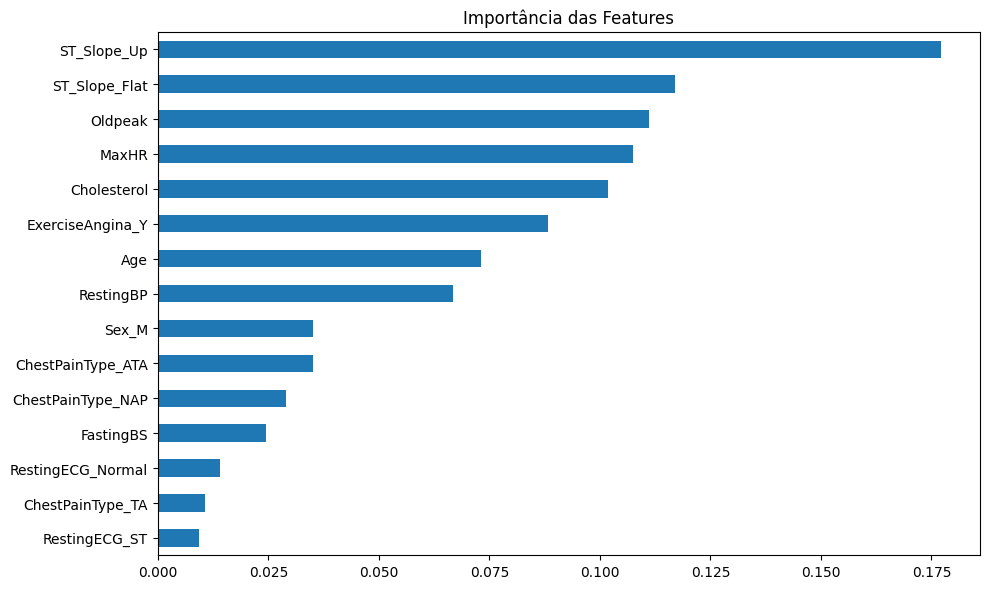

In [11]:
feature_names = (colunas_numericas +
    list(best_pipeline.named_steps['preprocessamento']
    .named_transformers_['cat']
    .get_feature_names_out(colunas_categoricas)))

importancias = best_pipeline.named_steps['modelo'].feature_importances_

pd.Series(importancias, index=feature_names).sort_values().plot(kind='barh', figsize=(10, 6))
plt.title('Importância das Features')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()

In [12]:
joblib.dump(best_pipeline, 'modelo_cardiaco.pkl')
print("\nModelo salvo com sucesso.")


Modelo salvo com sucesso.
